In [1]:
# show C-level stderr/stdout
%load_ext lab_black
%load_ext wurlitzer
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
import math
import numpy as np
import torch
import torch.nn as nn
import sklearn.datasets
from torchinfo import summary

from tqdm.auto import tqdm

## Spectral Normalized Gaussian Process

Based on official TensorFlow [tutorial](https://www.tensorflow.org/tutorials/understanding/sngp?hl=en).

Important source code:
1. SNGP on ImageNet ([here](https://github.com/google/uncertainty-baselines/blob/main/baselines/imagenet/sngp.py#L23)); **NOTE** is important: all classes share the same covariance
2. Random Fourier Features ([here](https://github.com/google/edward2/blob/main/edward2/tensorflow/layers/random_feature.py))
3. Mean Field Logits ([here](https://github.com/google/edward2/blob/main/edward2/tensorflow/layers/utils.py#L349))

In [4]:
plt.rcParams["figure.dpi"] = 140

DEFAULT_X_RANGE = (-3.5, 3.5)
DEFAULT_Y_RANGE = (-2.5, 2.5)
DEFAULT_CMAP = colors.ListedColormap(["#377eb8", "#ff7f00"])
DEFAULT_NORM = colors.Normalize(
    vmin=0,
    vmax=1,
)
DEFAULT_N_GRID = 100

In [5]:
def make_training_data(sample_size=500):
    """Create two moon training dataset."""
    train_examples, train_labels = sklearn.datasets.make_moons(
        n_samples=2 * sample_size, noise=0.1
    )

    # Adjust data position slightly.
    train_examples[train_labels == 0] += [-0.1, 0.2]
    train_examples[train_labels == 1] += [0.1, -0.2]

    return train_examples, train_labels

In [88]:
def make_testing_data(
    x_range=DEFAULT_X_RANGE, y_range=DEFAULT_Y_RANGE, n_grid=DEFAULT_N_GRID
):
    """Create a mesh grid in 2D space."""
    # testing data (mesh grid over data space)
    x = np.linspace(x_range[0], x_range[1], n_grid)
    y = np.linspace(y_range[0], y_range[1], n_grid)
    xx, yy = np.meshgrid(x, y)
    return xx, yy, np.stack([xx.flatten(), yy.flatten()], axis=-1)

In [89]:
def make_ood_data(sample_size=500, means=(2.5, -1.75), vars=(0.01, 0.01)):
    return np.random.multivariate_normal(means, cov=np.diag(vars), size=sample_size)

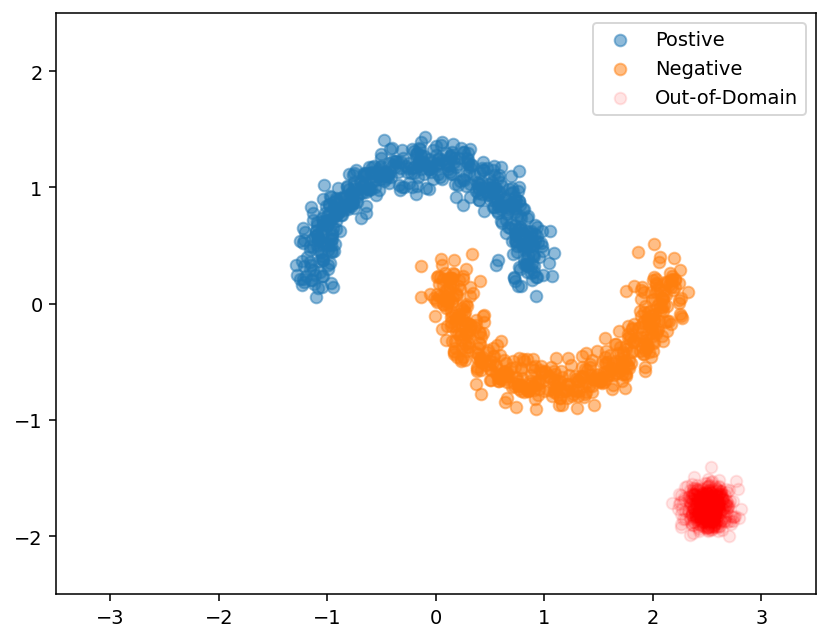

In [105]:
# Load the train, test and OOD datasets.
train_examples, train_labels = make_training_data(sample_size=500)
xx, yy, test_examples = make_testing_data()
ood_examples = make_ood_data(sample_size=500)

# Visualize
pos_examples = train_examples[train_labels == 0]
neg_examples = train_examples[train_labels == 1]

fig, ax = plt.subplots(1, 1, figsize=(7, 5.5))

ax.scatter(pos_examples[:, 0], pos_examples[:, 1], c="C0", alpha=0.5)
ax.scatter(neg_examples[:, 0], neg_examples[:, 1], c="C1", alpha=0.5)
ax.scatter(ood_examples[:, 0], ood_examples[:, 1], c="red", alpha=0.1)

ax.legend(["Postive", "Negative", "Out-of-Domain"])

ax.set_ylim(DEFAULT_Y_RANGE)
ax.set_xlim(DEFAULT_X_RANGE)

plt.show()

## Evaluating the Trained Model

1. Run the training script to obtain the model:
```bash
$ cd experiments
$ python mwp.py
```
2. Move the best model from `outputs/YYYY-mm-dd/hh-mm-ss/models/name.ckpt` to `experiments/models/name.ckpt`

In [106]:
from hydra.utils import to_absolute_path
from pathlib import Path
from sngp_pytorch import LitRandomFeatureGaussianProcess
import hydra
from hydra.core.global_hydra import GlobalHydra

GlobalHydra.instance().clear()
hydra.initialize(config_path="config")
cfg = hydra.compose("mwp.yaml")

checkpoint = "make_moons-epoch=169-val_loss=0.00.ckpt"
model_saved = to_absolute_path(Path("models", checkpoint))
model = LitRandomFeatureGaussianProcess.load_from_checkpoint(
    model_saved, backbone=nn.BatchNorm1d(cfg.make_data.n_dims)
)
model.eval()
model.model.update_covariance()

In [107]:
logits, variances = model(
    torch.from_numpy(test_examples).to(torch.float32),
    with_variance=True,
    mean_field=True,
)

probs = logits.detach().softmax(dim=-1).numpy()
variances = variances.numpy()
unc = variances / variances.max()

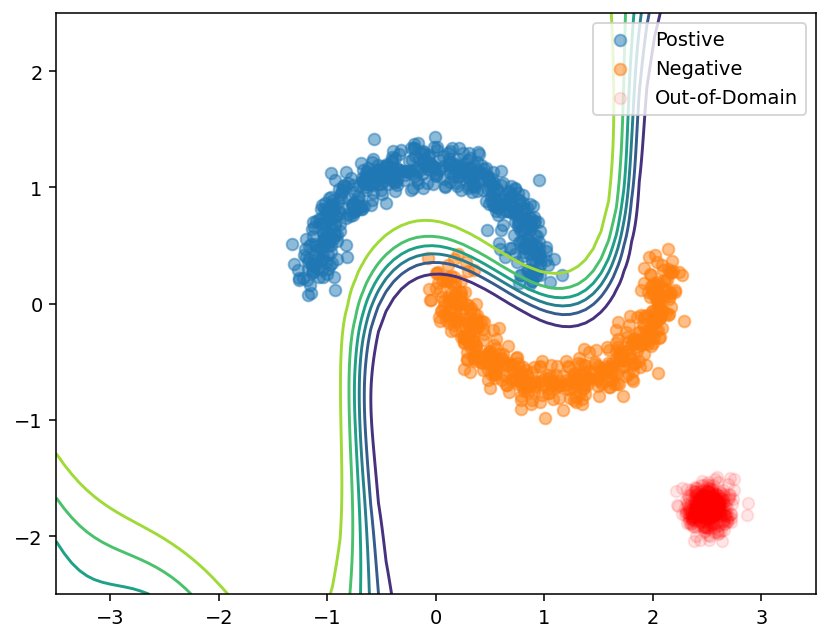

In [111]:
# Load the train, test and OOD datasets.
train_examples, train_labels = make_training_data(sample_size=500)
test_examples = make_testing_data()
ood_examples = make_ood_data(sample_size=500)

# Visualize
pos_examples = train_examples[train_labels == 0]
neg_examples = train_examples[train_labels == 1]

fig, ax = plt.subplots(1, 1, figsize=(7, 5.5))

ax.contour(
    xx,
    yy,
    probs[:, 0].reshape(DEFAULT_N_GRID, DEFAULT_N_GRID),
)

ax.scatter(pos_examples[:, 0], pos_examples[:, 1], c="C0", alpha=0.5)
ax.scatter(neg_examples[:, 0], neg_examples[:, 1], c="C1", alpha=0.5)
ax.scatter(ood_examples[:, 0], ood_examples[:, 1], c="red", alpha=0.1)

ax.legend(["Postive", "Negative", "Out-of-Domain"])

ax.set_ylim(DEFAULT_Y_RANGE)
ax.set_xlim(DEFAULT_X_RANGE)

plt.show()

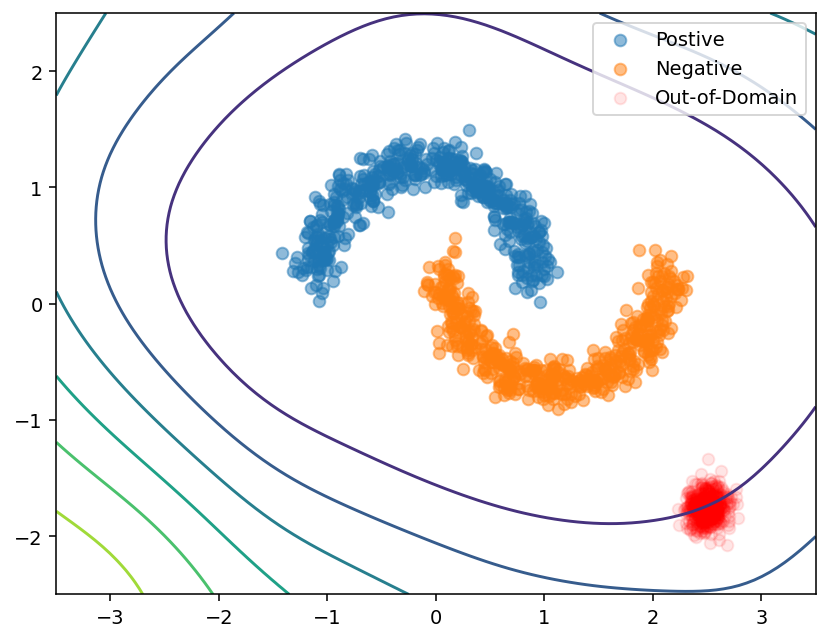

In [110]:
# Load the train, test and OOD datasets.
train_examples, train_labels = make_training_data(sample_size=500)
test_examples = make_testing_data()
ood_examples = make_ood_data(sample_size=500)

# Visualize
pos_examples = train_examples[train_labels == 0]
neg_examples = train_examples[train_labels == 1]

fig, ax = plt.subplots(1, 1, figsize=(7, 5.5))

ax.contour(
    xx,
    yy,
    unc.reshape(DEFAULT_N_GRID, DEFAULT_N_GRID),
)

ax.scatter(pos_examples[:, 0], pos_examples[:, 1], c="C0", alpha=0.5)
ax.scatter(neg_examples[:, 0], neg_examples[:, 1], c="C1", alpha=0.5)
ax.scatter(ood_examples[:, 0], ood_examples[:, 1], c="red", alpha=0.1)

ax.legend(["Postive", "Negative", "Out-of-Domain"])

ax.set_ylim(DEFAULT_Y_RANGE)
ax.set_xlim(DEFAULT_X_RANGE)

plt.show()